# 도로 영역을 찾자! - 세그멘테이션 모델 만들기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [8]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

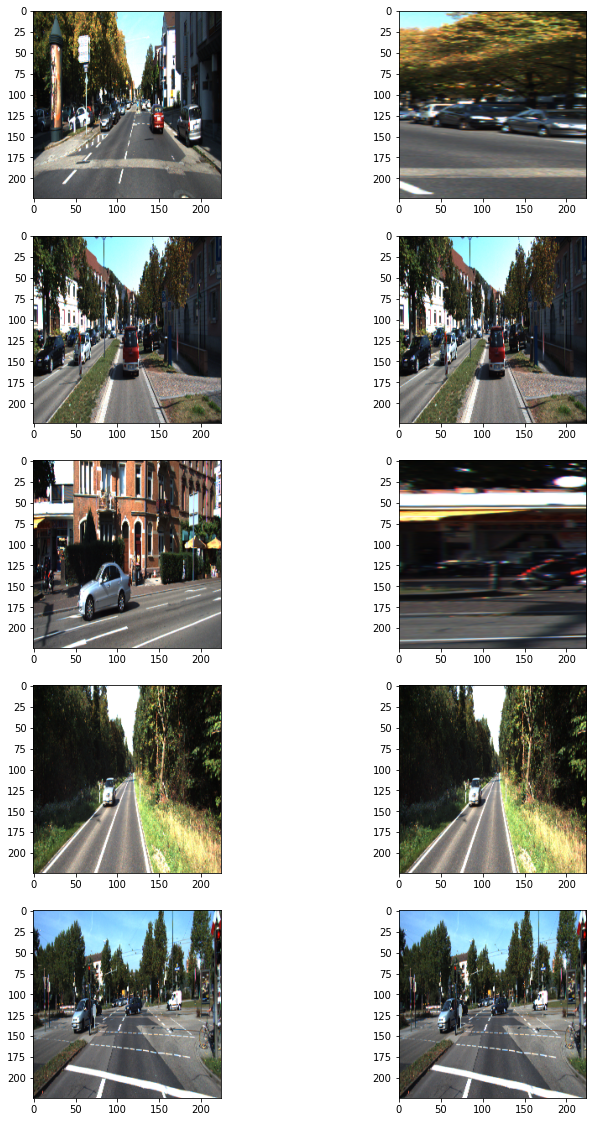

In [10]:
dir_path = '/content/drive/MyDrive/data/semantic_segmentation/data/training/'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [11]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [12]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-Net 모델 구조 만들기
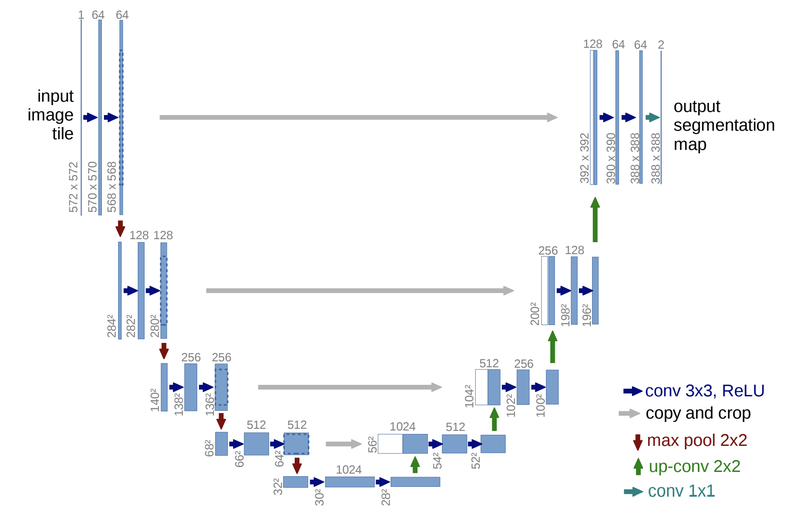

In [13]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
	
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

## 모델 학습

In [14]:
model_path = '/content/drive/MyDrive/data/semantic_segmentation/data/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 16s 353ms/step - loss: 0.6882 - val_loss: 0.6761
Epoch 2/100
11/11 [==============================] - 4s 321ms/step - loss: 0.6674 - val_loss: 0.6370
Epoch 3/100
11/11 [==============================] - 4s 320ms/step - loss: 0.3160 - val_loss: 0.0367
Epoch 4/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0374 - val_loss: 0.0370
Epoch 5/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0300 - val_loss: 0.0343
Epoch 6/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0290 - val_loss: 0.0291
Epoch 7/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0298 - val_loss: 0.0325
Epoch 8/100
11/11 [==============================] - 4s 321ms/step - loss: 0.0258 - val_loss: 0.0254
Epoch 9/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0279 - val_loss: 0.0328
Epoch 10/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0237 - val_l

###  시맨틱 세그멘테이션 모델 시각화

In [15]:
model = tf.keras.models.load_model(model_path)

In [16]:
def get_output(model, preproc, image_path, output_path):
    # image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

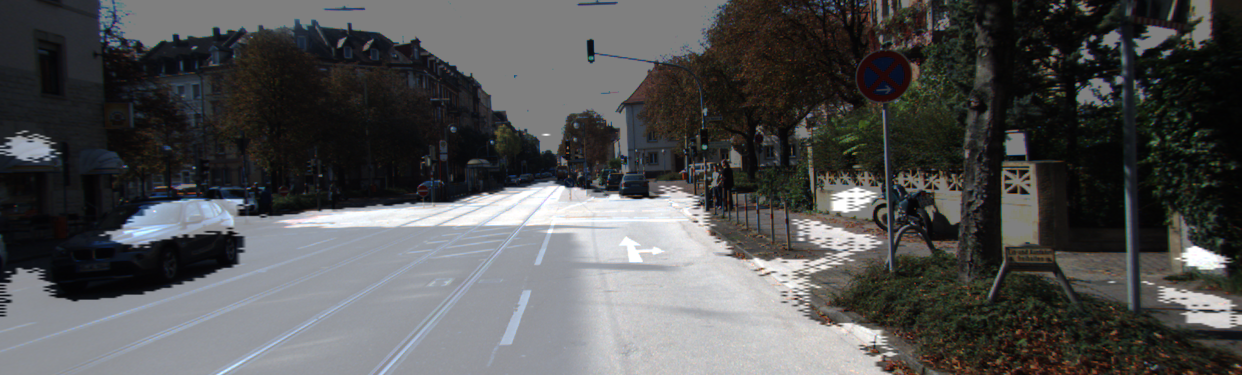

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [18]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [19]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.861924


0.8619238055146285

## 프로젝트 : 개선된 U-Net 모델 만들기
- U-Net++
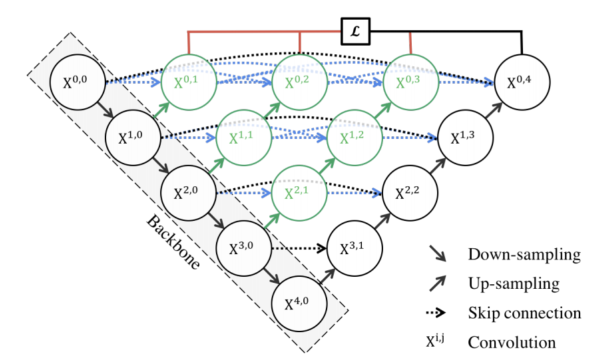

In [94]:
def build_unetpp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    x0_0 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(inputs)
    x0_0 = BatchNormalization()(x0_0)
    x0_0 = Activation('relu')(x0_0)
    x0_0 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(x0_0)
    x0_0 = BatchNormalization()(x0_0)
    x0_0 = Activation('relu')(x0_0)
    c0_0 = MaxPooling2D(pool_size=(2, 2))(x0_0)

    x1_0 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(c0_0)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Activation('relu')(x1_0)
    x1_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x1_0)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Activation('relu')(x1_0)
    c1_0 = MaxPooling2D(pool_size=(2, 2))(x1_0)

    x2_0 = Conv2D(128, 3, padding='same',kernel_initializer='he_normal')(c1_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, padding='same',kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Activation('relu')(x2_0)
    c2_0 = MaxPooling2D(pool_size=(2, 2))(x2_0)

    x3_0 = Conv2D(256, 3, padding='same',kernel_initializer='he_normal')(c2_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Activation('relu')(x3_0)
    x3_0 = Conv2D(256, 3, padding='same',kernel_initializer='he_normal')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Activation('relu')(x3_0)
    c3_0 = MaxPooling2D(pool_size=(2, 2))(x3_0)

    x4_0 = Conv2D(512, 3, padding='same',kernel_initializer='he_normal')(c3_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Activation('relu')(x4_0)
    x4_0 = Conv2D(512, 3, padding='same',kernel_initializer='he_normal')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Activation('relu')(x4_0)

    up1_0 = Conv2DTranspose(32, 2, strides=(2,2), kernel_initializer='he_normal')(x1_0)
    merge0_1 = concatenate([up1_0,x0_0], axis = 3)
    x0_1 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(merge0_1)
    x0_1 = BatchNormalization()(x0_1)
    x0_1 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(x0_1)
    x0_1 = BatchNormalization()(x0_1)

    up2_0 = Conv2DTranspose(64, 2, strides=(2,2), kernel_initializer='he_normal')(x2_0)
    merge1_1 = concatenate([up2_0,x1_0], axis = 3)
    x1_1 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(merge1_1)
    x1_1 = BatchNormalization()(x1_1)
    x1_1 = Activation('relu')(x1_1)
    x1_1 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(x1_1)
    x1_1 = BatchNormalization()(x1_1)
    x1_1 = Activation('relu')(x1_1)

    up3_0 = Conv2DTranspose(128, 2, strides=(2,2), kernel_initializer='he_normal')(x3_0)
    merge2_1 = concatenate([up3_0,x2_0], axis = 3)
    x2_1 = Conv2D(128, 3, padding='same',kernel_initializer='he_normal')(merge2_1)
    x2_1 = BatchNormalization()(x2_1)
    x2_1 = Activation('relu')(x2_1)
    x2_1 = Conv2D(128, 3, padding='same',kernel_initializer='he_normal')(x2_1)
    x2_1 = BatchNormalization()(x2_1)
    x2_1 = Activation('relu')(x2_1)

    up4_0 = Conv2DTranspose(256, 2, strides=(2,2), kernel_initializer='he_normal')(x4_0)
    merge3_1 = concatenate([up4_0,x3_0], axis = 3)
    x3_1 = Conv2D(256, 3, padding='same',kernel_initializer='he_normal')(merge3_1)
    x3_1 = BatchNormalization()(x3_1)
    x3_1 = Activation('relu')(x3_1)
    x3_1 = Conv2D(256, 3, padding='same',kernel_initializer='he_normal')(x3_1)
    x3_1 = BatchNormalization()(x3_1)
    x3_1 = Activation('relu')(x3_1)

    up1_1 = Conv2DTranspose(32, 2, strides=(2,2), kernel_initializer='he_normal')(x1_1)
    merge0_2 = concatenate([up1_1,x0_1,x0_0], axis = 3)
    x0_2 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(merge0_2)
    x0_2 = BatchNormalization()(x0_2)
    x0_2 = Activation('relu')(x0_2)
    x0_2 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(x0_2)
    x0_2 = BatchNormalization()(x0_2)
    x0_2 = Activation('relu')(x0_2)

    up2_1 = Conv2DTranspose(64, 2, strides=(2,2), kernel_initializer='he_normal')(x2_1)
    merge1_2 = concatenate([up2_1,x1_1,x1_0], axis = 3)
    x1_2 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(merge1_2)
    x1_2 = BatchNormalization()(x1_2)
    x1_2 = Activation('relu')(x1_2)
    x1_2 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(x1_2)
    x1_2 = BatchNormalization()(x1_2)
    x1_2 = Activation('relu')(x1_2)

    up3_1 = Conv2DTranspose(128, 2, strides=(2,2), kernel_initializer='he_normal')(x3_1)
    merge2_2 = concatenate([up3_1,x2_1,x2_0], axis = 3)
    x2_2 = Conv2D(128, 3, padding='same',kernel_initializer='he_normal')(merge2_2)
    x2_2 = BatchNormalization()(x2_2)
    x2_2 = Activation('relu')(x2_2)
    x2_2 = Conv2D(128, 3, padding='same',kernel_initializer='he_normal')(x2_2)
    x2_2 = BatchNormalization()(x2_2)
    x2_2 = Activation('relu')(x2_2)

    up1_2 = Conv2DTranspose(32, 2, strides=(2,2), kernel_initializer='he_normal')(x1_2)
    merge0_3 = concatenate([up1_2,x0_2,x0_1,x0_0], axis = 3)
    x0_3 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(merge0_3)
    x0_3 = BatchNormalization()(x0_3)
    x0_3 = Activation('relu')(x0_3)
    x0_3 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(x0_3)
    x0_3 = BatchNormalization()(x0_3)
    x0_3 = Activation('relu')(x0_3)

    up2_2 = Conv2DTranspose(64, 2, strides=(2,2), kernel_initializer='he_normal')(x2_2)
    merge1_3 = concatenate([up2_2,x1_2,x1_1,x1_0], axis = 3)
    x1_3 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(merge1_3)
    x1_3 = BatchNormalization()(x1_3)
    x1_3 = Conv2D(64, 3, padding='same',kernel_initializer='he_normal')(x1_3)
    x1_3 = BatchNormalization()(x1_3)

    up1_3 = Conv2DTranspose(32, 2, strides=(2,2), kernel_initializer='he_normal')(x1_3)
    merge0_4 = concatenate([up1_3,x0_3,x0_2,x0_1,x0_0], axis = 3)
    x0_4 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(merge0_4)
    x0_4 = BatchNormalization()(x0_4)
    x0_4 = Activation('relu')(x0_4)
    x0_4 = Conv2D(32, 3, padding='same',kernel_initializer='he_normal')(x0_4)
    x0_4 = BatchNormalization()(x0_4)
    x0_4 = Activation('relu')(x0_4)

    outputs = Conv2D(1, 1, activation='sigmoid')(x0_4)

    model = Model(inputs = inputs, outputs = outputs)
    return model

In [95]:
unetpp = build_unetpp()

In [96]:
unetpp.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_112 (Conv2D)            (None, 224, 224, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_90 (BatchN  (None, 224, 224, 32  128        ['conv2d_112[0][0]']             
 ormalization)                  )                                                           

In [97]:
unetpp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unetpp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unetpp_path = dir_path + '/seg_model_unetpp.h5'
unetpp.save(unetpp_path)  # 학습한 모델을 저장해 주세요.

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


11/11 [==============================] - 9s 443ms/step - loss: 0.7980 - val_loss: 0.6939
Epoch 2/100
11/11 [==============================] - 4s 372ms/step - loss: 0.7101 - val_loss: 0.6857
Epoch 3/100
11/11 [==============================] - 4s 373ms/step - loss: 0.6564 - val_loss: 0.6731
Epoch 4/100
11/11 [==============================] - 4s 372ms/step - loss: 0.6156 - val_loss: 0.6996
Epoch 5/100
11/11 [==============================] - 4s 373ms/step - loss: 0.5826 - val_loss: 0.6604
Epoch 6/100
11/11 [==============================] - 4s 373ms/step - loss: 0.5841 - val_loss: 0.6714
Epoch 7/100
11/11 [==============================] - 4s 374ms/step - loss: 0.5648 - val_loss: 0.6819
Epoch 8/100
11/11 [==============================] - 4s 373ms/step - loss: 0.5445 - val_loss: 1.0112
Epoch 9/100
11/11 [==============================] - 4s 372ms/step - loss: 0.5235 - val_loss: 0.8671
Epoch 10/100
11/11 [==============================] - 4s 373ms/step - loss: 0.5254 - val_loss: 0.7915
E

## U-Net, U-Net++ 결과 분석

In [98]:
unet_path = '/content/drive/MyDrive/data/semantic_segmentation/data/seg_model_unet.h5'
unetpp_path = '/content/drive/MyDrive/data/semantic_segmentation/data/training/seg_model_unetpp.h5'

unet = tf.keras.models.load_model(unet_path)
unetpp = tf.keras.models.load_model(unetpp_path)

In [99]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

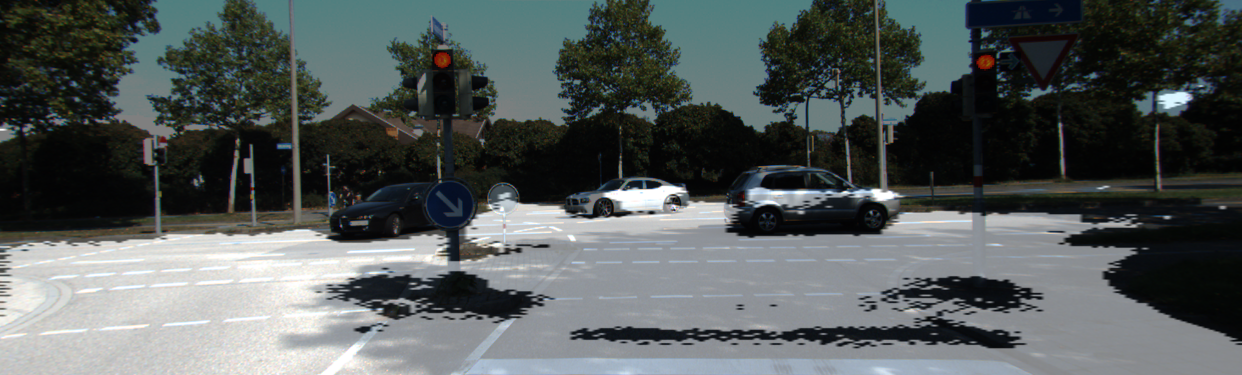

In [100]:
i = 10    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [101]:
get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [102]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [109]:
i = 11    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.698905


0.698905204171639

In [110]:
output, prediction, target = get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.749394


0.7493940210072717

In [111]:
unet_iou = []
unetpp_iou = []

In [112]:
for i in range(1,51):
    output, prediction, target = get_output(
        unet, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )
    unet_iou.append(calculate_iou_score(target, prediction))
    output, prediction, target = get_output(
        unetpp, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )
    unetpp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.861924
IoU : 0.757263
IoU : 0.595984
IoU : 0.667511
IoU : 0.557107
IoU : 0.433191
IoU : 0.499642
IoU : 0.734454
IoU : 0.432838
IoU : 0.770541
IoU : 0.335963
IoU : 0.651503
IoU : 0.608316
IoU : 0.703414
IoU : 0.621506
IoU : 0.364647
IoU : 0.679995
IoU : 0.591128
IoU : 0.685112
IoU : 0.735200
IoU : 0.698905
IoU : 0.749394
IoU : 0.665442
IoU : 0.722919
IoU : 0.626012
IoU : 0.708048
IoU : 0.544596
IoU : 0.820261
IoU : 0.744344
IoU : 0.847245
IoU : 0.771377
IoU : 0.845662
IoU : 0.734966
IoU : 0.842105
IoU : 0.624146
IoU : 0.216991
IoU : 0.641076
IoU : 0.478280
IoU : 0.755709
IoU : 0.520884
IoU : 0.307204
IoU : 0.444420
IoU : 0.849423
IoU : 0.839454
IoU : 0.765800
IoU : 0.797593
IoU : 0.633830
IoU : 0.671959
IoU : 0.583565
IoU : 0.583487
IoU : 0.567310
IoU : 0.537520
IoU : 0.701709
IoU : 0.652678
IoU : 0.734174
IoU : 0.513848
IoU : 0.614665
IoU : 0.740287
IoU : 0.666346
IoU : 0.746180
IoU : 0.673364
IoU : 0.603231
IoU : 0.655066
IoU : 0.714070
IoU : 0.696266
IoU : 0.620550
IoU : 0.55

In [114]:
print('U-Net 점수 :',sum(unet_iou)/50)
print('U-Net++ 점수 :',sum(unetpp_iou)/50)

U-Net 점수 : 0.6345363997875773
U-Net++ 점수 : 0.691893020419717


- 50개의 이미지로 테스트해서, iou 점수를 평균내보았는데, unet++가 더 나은 성능을 보이는 것을 확인했다.
- 모델 만드는건 아직도 좀 헷갈린다. 그래도 resnet 구현해봤던 것 덕분에 조금은 수월하게 진행된 것 같다.